In [1]:
!pip install qiskit qiskit-ibm-runtime matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.4 MB/s eta 0:00:00


<ipython-input-23-f8d6f6f6355b>:71: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


Backend selecionado: <IBMBackend('ibm_sherbrooke')>


/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


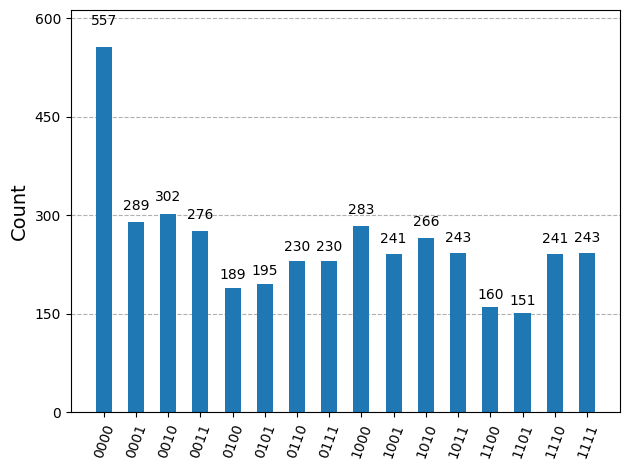

In [23]:
%matplotlib inline

# Qiskit core
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# IBM Quantum
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Options,
    Session,
    Estimator
)
from qiskit_ibm_runtime.fake_provider import FakeKyiv

# Auxiliares
import numpy as np
import random
import math
from fractions import Fraction

# Visualização
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Parâmetros
n = 4
oracle_target = '0000'

# 1. Inicialização
grover_circuit = QuantumCircuit(n, n)
grover_circuit.h(range(n))

# 2. Oráculo
def apply_oracle(qc, target: str):
    for i, bit in enumerate(reversed(target)):
        if bit == '0':
            qc.x(i)
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    for i, bit in enumerate(reversed(target)):
        if bit == '0':
            qc.x(i)

# 3. Difusor (amplificação)
def diffusion_operator(qc):
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))

# Número de iterações de Grover
num_iterations = math.floor((math.pi / 4) * math.sqrt(2**n))

for _ in range(num_iterations):
    apply_oracle(grover_circuit, oracle_target)
    diffusion_operator(grover_circuit)
    grover_circuit.barrier()

# 4. Medição
grover_circuit.measure(range(n), range(n))

# Autenticação e seleção de backend IBM
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="5b7ea1878d98ab8a27e8ccd5a7f2b8ffc3a131536a1f97f88fbf9cffa5477d474c796d7250935e8c8d6e55071d7668debeed206bc16617c418e09010ee3878ef"
)
backend = service.least_busy(operational=True, simulator=False)
print("Backend selecionado:", backend)

# Transpilação
transpiled_circuit = transpile(grover_circuit, backend)

# Submissão do job
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit])
result = job.result()[0]

# Exibição de resultados inline
counts = result.data.c.get_counts()

# Gere a figura e deixe o Jupyter exibi-la automaticamente
fig = plot_histogram(counts)
fig

